In [21]:
import os
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
)
from sklearn.exceptions import UndefinedMetricWarning
import warnings

In [23]:
TRAIN_CSV = "kdd_train.csv"
TEST_CSV = "kdd_test.csv"
OUTPUT_PRED_CSV = "kdd_predictions_binary.csv"

# Optional: silence the specific sklearn undefined metric warnings in reports
warnings.filterwarnings(action="default", category=UndefinedMetricWarning)

In [25]:
def load_csv(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}\nPut the CSV in the same folder or give the full path.")
    # try common encodings if default fails
    try:
        return pd.read_csv(path)
    except UnicodeDecodeError:
        return pd.read_csv(path, encoding="latin-1")

train_df = load_csv(TRAIN_CSV)
test_df = load_csv(TEST_CSV)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (125973, 42)
Test shape: (22544, 42)


In [29]:
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()
print("Columns:", train_df.columns.tolist())


Columns: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'labels']


In [31]:
if 'labels' not in train_df.columns or 'labels' not in test_df.columns:
    raise KeyError("Expected column 'labels' in both train and test CSVs. Check your column names.")

train_df['labels'] = train_df['labels'].apply(lambda x: 0 if str(x).strip().lower() == 'normal' else 1)
test_df['labels'] = test_df['labels'].apply(lambda x: 0 if str(x).strip().lower() == 'normal' else 1)


In [33]:
categorical_cols = [c for c in ['protocol_type', 'service', 'flag'] if c in train_df.columns]
feature_cols = [c for c in train_df.columns if c != 'labels']

numeric_cols = [c for c in feature_cols if c not in categorical_cols]

print("Categorical columns:", categorical_cols)
print("Numeric columns (sample):", numeric_cols[:8], "... total", len(numeric_cols))

Categorical columns: ['protocol_type', 'service', 'flag']
Numeric columns (sample): ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins'] ... total 38


In [39]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ],
    remainder='drop'
)

In [41]:
model = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', solver='lbfgs'))
])

In [43]:
X_train = train_df[feature_cols]
y_train = train_df['labels'].astype(int)

X_test = test_df[feature_cols]
y_test = test_df['labels'].astype(int)


In [45]:
print("Training model... this may take a moment depending on dataset size.")
model.fit(X_train, y_train)
print("Training complete.")

Training model... this may take a moment depending on dataset size.
Training complete.


In [47]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # probability of class 1 (attack)

# --- Step 9: Evaluation ---
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

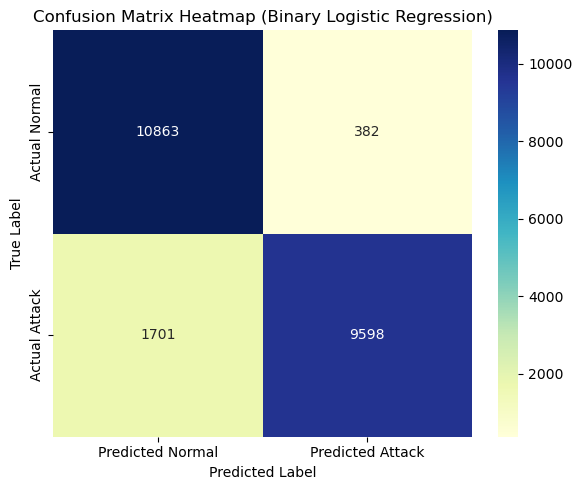

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a labeled heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar=True,
            xticklabels=['Predicted Normal', 'Predicted Attack'],
            yticklabels=['Actual Normal', 'Actual Attack'])

plt.title("Confusion Matrix Heatmap (Binary Logistic Regression)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


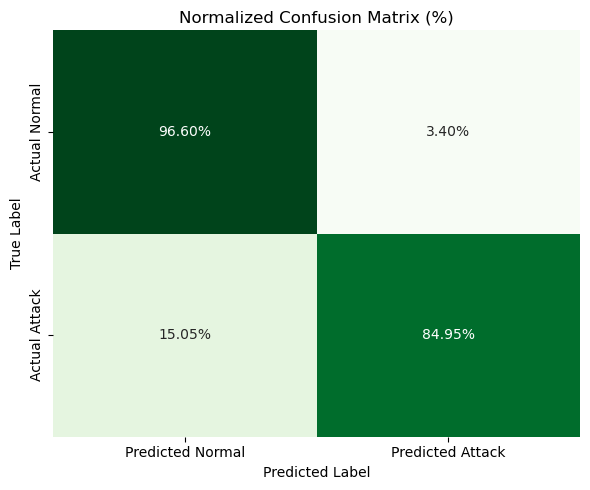

In [57]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', cbar=False,
            xticklabels=['Predicted Normal', 'Predicted Attack'],
            yticklabels=['Actual Normal', 'Actual Attack'])
plt.title("Normalized Confusion Matrix (%)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [49]:
report = classification_report(y_test, y_pred, zero_division=0)
try:
    roc_auc = roc_auc_score(y_test, y_prob)
except ValueError:
    # If only one class present in test set, roc_auc_score will fail
    roc_auc = float('nan')

print("\n--- Evaluation ---")
print(f"Accuracy: {acc:.4f}")
print(f"ROC AUC: {roc_auc}")
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)


--- Evaluation ---
Accuracy: 0.9076
ROC AUC: 0.9275449599473875

Confusion Matrix:
 [[10863   382]
 [ 1701  9598]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.97      0.91     11245
           1       0.96      0.85      0.90     11299

    accuracy                           0.91     22544
   macro avg       0.91      0.91      0.91     22544
weighted avg       0.91      0.91      0.91     22544



In [51]:
unique_true = np.unique(y_test)
unique_pred = np.unique(y_pred)
print("Labels in test set:", unique_true)
print("Labels predicted:", unique_pred)

Labels in test set: [0 1]
Labels predicted: [0 1]



Predictions saved to kdd_predictions_binary.csv
